# Аугентация на практике.

In [1]:
%cd drive/MyDrive/YaMlProject

/content/drive/MyDrive/YaMlProject


Импорт необходимых библиотек

In [2]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%cd drive/MyDrive/YaMlProject
%ls

[Errno 2] No such file or directory: 'drive/MyDrive/YaMlProject'
/content/drive/MyDrive/YaMlProject
core/  data/  models/  notebooks/  README.md  requirements.txt


In [1]:
import sys

import numpy as np
from PIL import Image
import tensorflow as tf
import torchvision as tv
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

sys.path.append('../../../')

from core.datasets import get_ds, DataSequence, open_f

Скачаем датасеты

In [2]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', back=3, batch_size=512)

Напишем функцию для отображения датасета с применнеными вариантами аугментаций

In [3]:
def draw_aug_ds(transformer):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        img = np.array(transformer(Image.fromarray((train_ds[i][0][0] * 255).astype(np.uint8), 'RGB')))
        plt.imshow(img / 255, cmap=plt.cm.binary)
        plt.title(train_ds[i][1][0])
        plt.axis('off')
    plt.show()

Напишем все варианты аугментации

In [4]:
crop = tv.transforms.CenterCrop(size=(28, 22))
inverter = tv.transforms.RandomInvert(p=0.4)
posterizer = tv.transforms.RandomPosterize(bits=6, p=0.4)
jitter = tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5)
perspective = tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4)
affine = tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1))
gray_scale = tv.transforms.Grayscale(num_output_channels=3)
solarizer = tv.transforms.RandomSolarize(threshold=100.0, p=0.4)
equalizer = tv.transforms.RandomEqualize(p=0.4)

Теперь будем комбинировать их и проверять на модели. На фото изображен график обучения модели без агументации. Как можно заметить по графику лосса есть переобучение. 
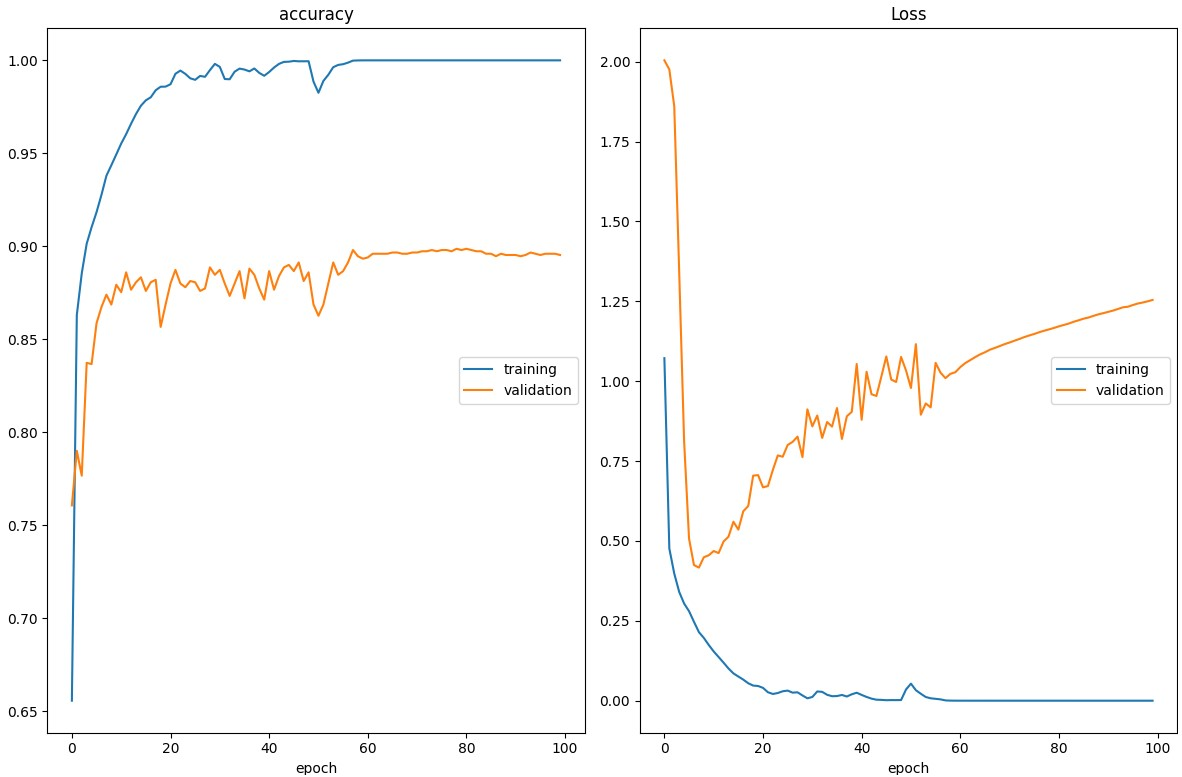

Для проверки работоспособности аугментаций, мы будем использовать эту же модель.

In [5]:
model_retrain = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3), batch_size=512),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_retrain.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (512, 30, 30, 32)         896       
                                                                 
 conv2d_1 (Conv2D)           (512, 28, 28, 64)         18496     
                                                                 
 batch_normalization (BatchN  (512, 28, 28, 64)        256       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (512, 14, 14, 64)        0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (512, 12, 12, 64)         36928     
                                                                 
 average_pooling2d_1 (Averag  (512, 6, 6, 64)          0

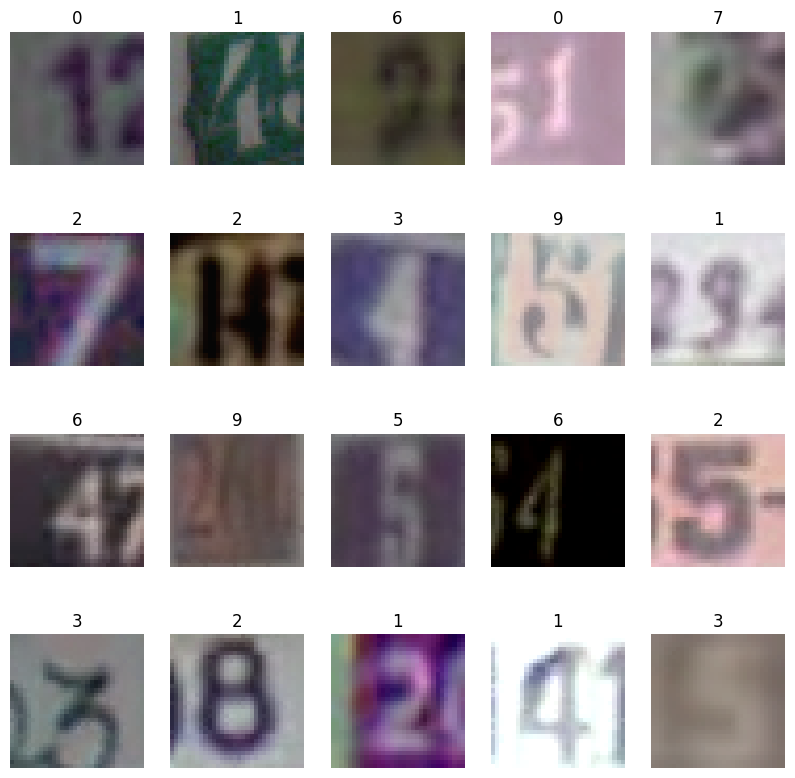

In [11]:
transformer1 = tv.transforms.Compose([
    jitter,
    inverter
])
draw_aug_ds(transformer1)

In [ ]:
train_ds.transform = transformer1
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

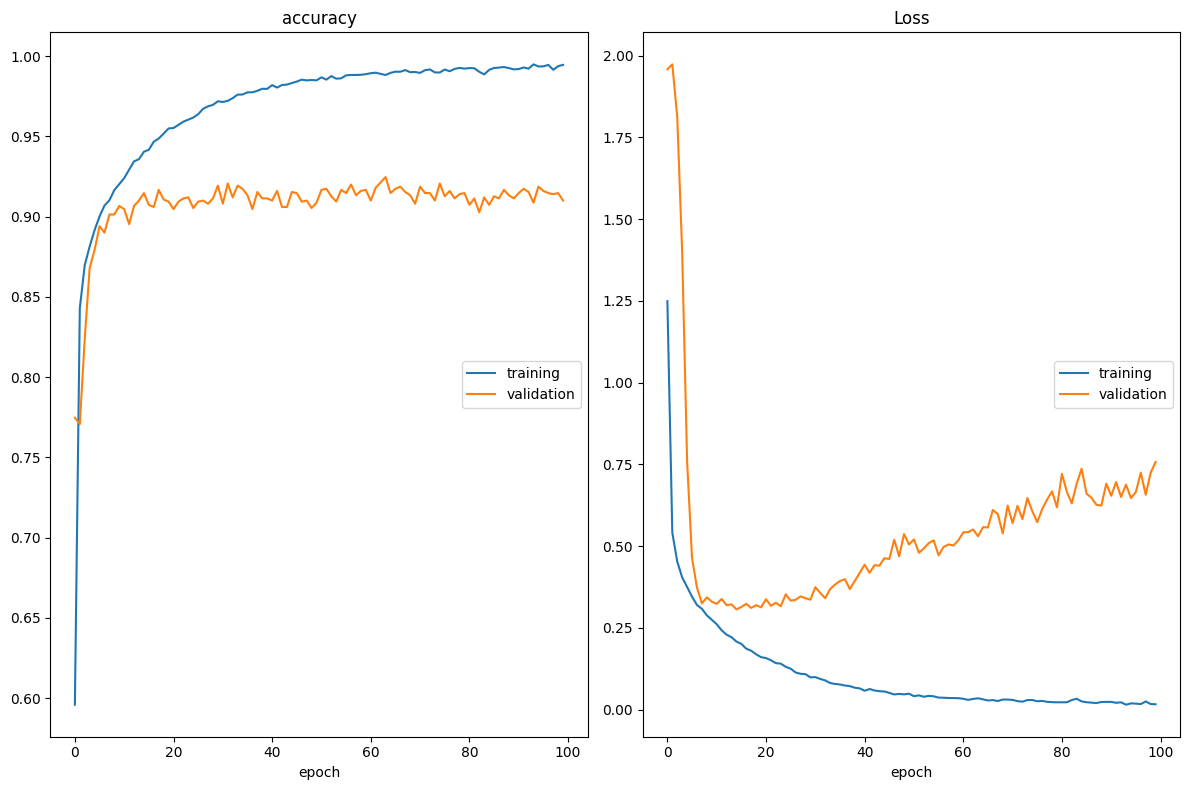

accuracy
	training         	 (min:    0.596, max:    0.995, cur:    0.995)
	validation       	 (min:    0.771, max:    0.925, cur:    0.910)
Loss
	training         	 (min:    0.015, max:    1.249, cur:    0.017)
	validation       	 (min:    0.307, max:    1.973, cur:    0.757)


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Модель только с цветокоррекцией работает не очень хорошо, быстро переобучается

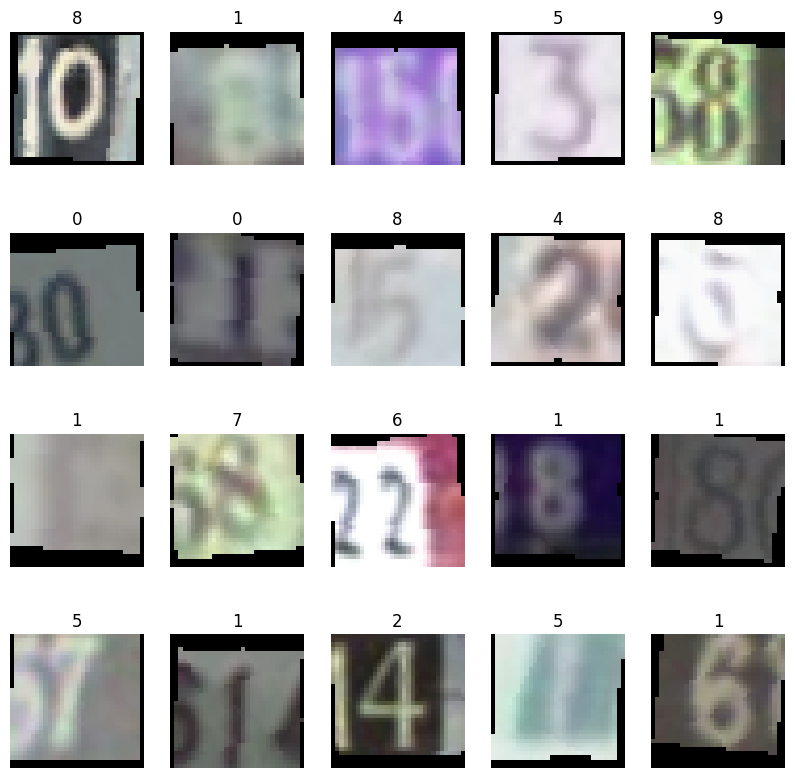

In [ ]:
transformer2 = tv.transforms.Compose([
    tv.transforms.RandomPerspective(distortion_scale=0.1, p=1.0),
    tv.transforms.RandomAffine(degrees=(-7, 7), translate=(0, 0.1), scale=(0.95, 1))
])
draw_aug_ds(transformer2)

In [ ]:
train_ds.transform = transformer2
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

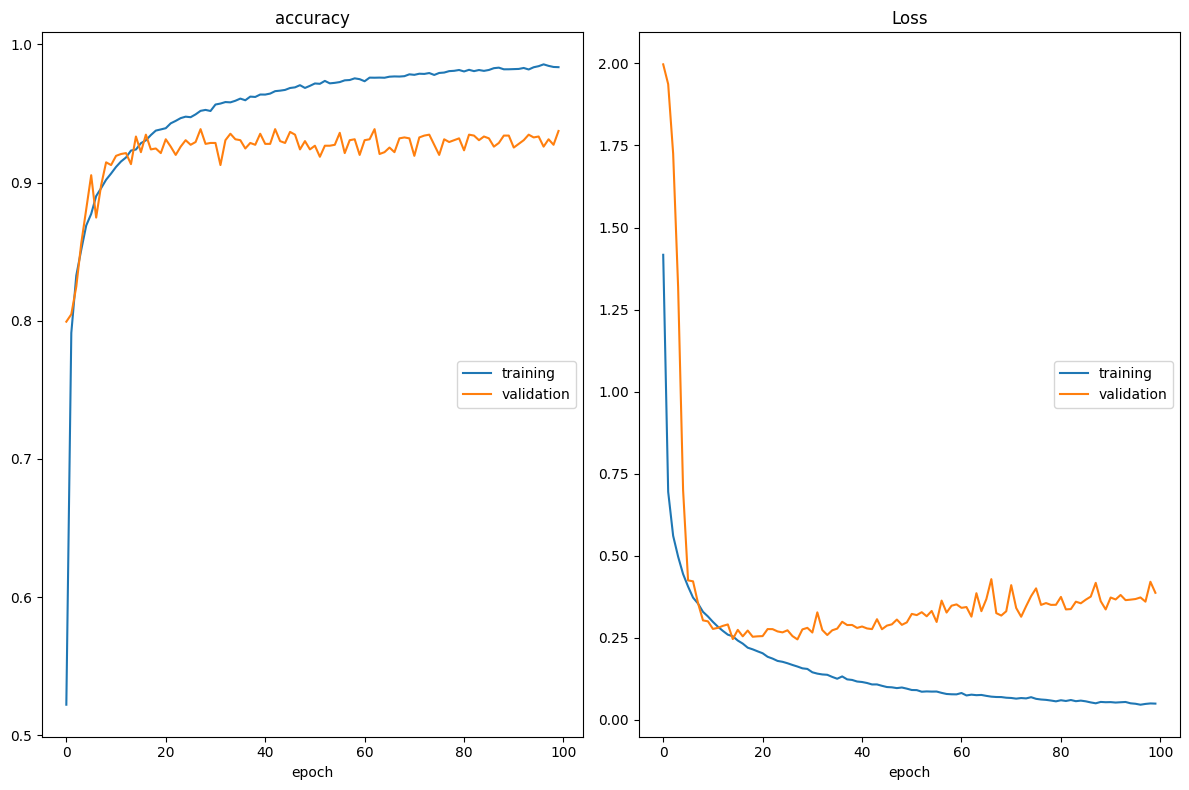

accuracy
	training         	 (min:    0.522, max:    0.986, cur:    0.984)
	validation       	 (min:    0.799, max:    0.939, cur:    0.937)
Loss
	training         	 (min:    0.045, max:    1.417, cur:    0.049)
	validation       	 (min:    0.244, max:    1.997, cur:    0.387)


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Смена перспективы, поворот сильно помогает модели не переобучаться, модель показывает неплохие результаты, но это не лучший вариант

----

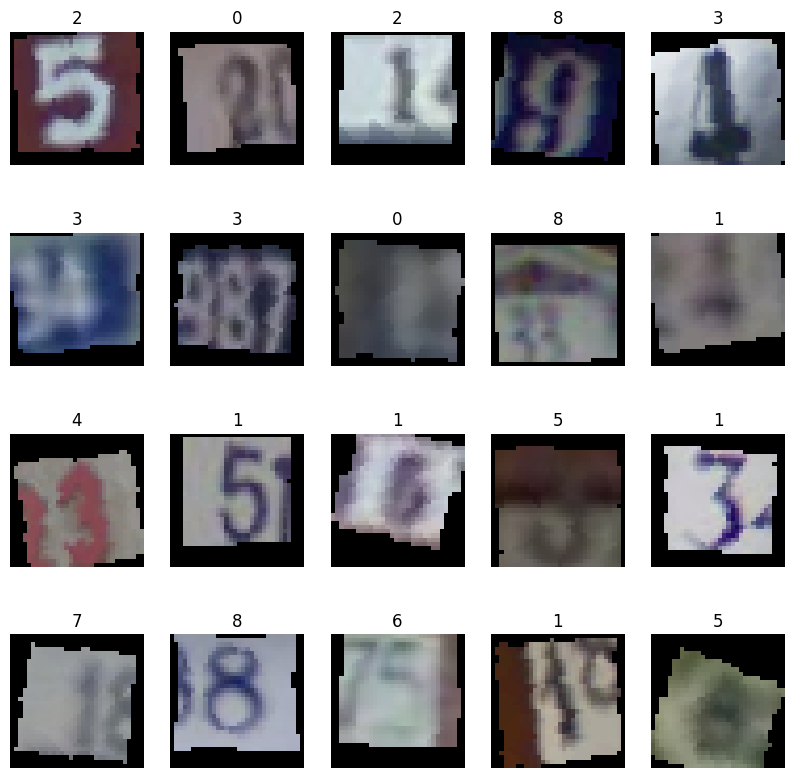

In [ ]:
transformer3 = tv.transforms.Compose([
    posterizer,
    affine,
])
draw_aug_ds(transformer3)

In [ ]:
train_ds.transform = transformer3
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

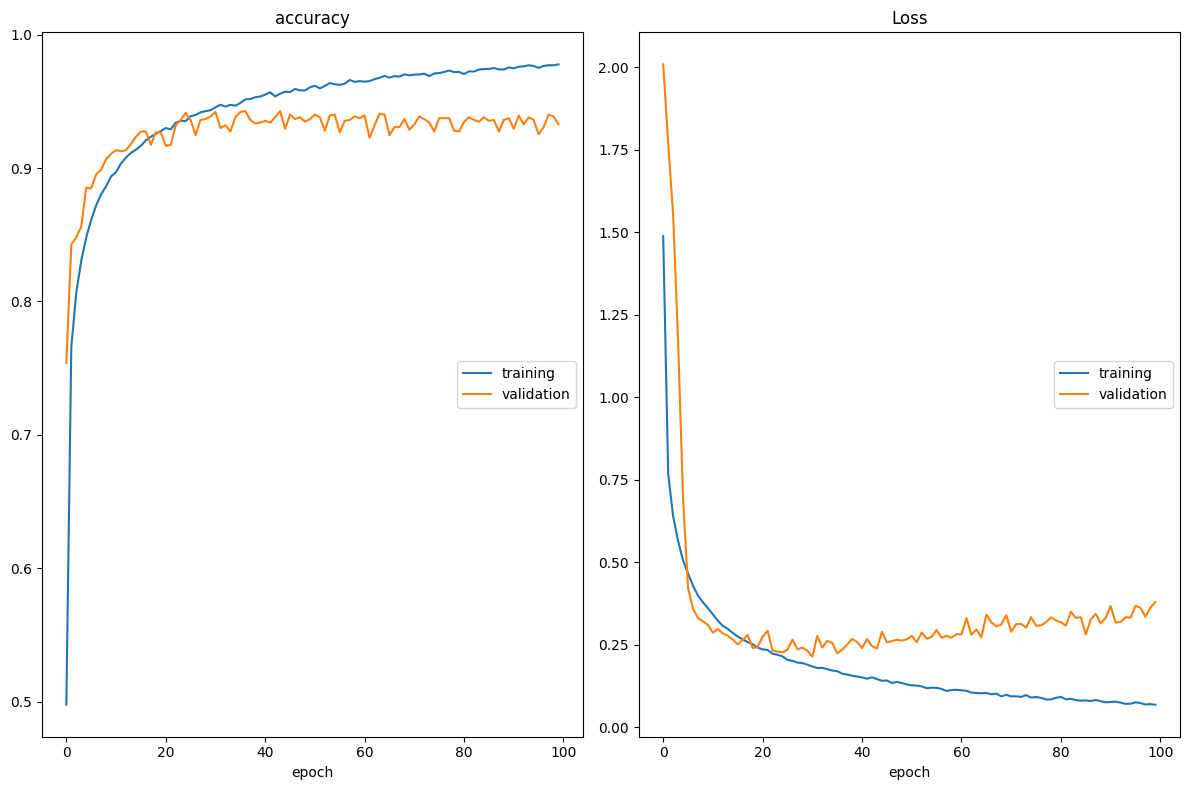

accuracy
	training         	 (min:    0.498, max:    0.978, cur:    0.978)
	validation       	 (min:    0.754, max:    0.943, cur:    0.933)
Loss
	training         	 (min:    0.069, max:    1.488, cur:    0.069)
	validation       	 (min:    0.214, max:    2.008, cur:    0.380)


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Модель показывает хорошие результаты, аугментация действительно хорошая

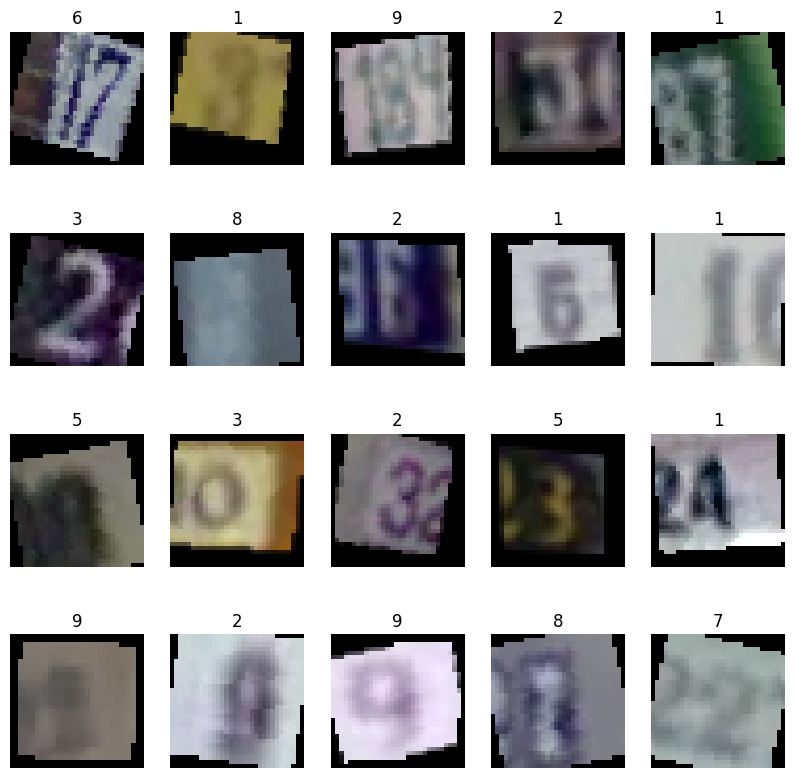

In [6]:
transformer4 = tv.transforms.Compose([
    jitter,
    affine,
    perspective
])
draw_aug_ds(transformer4)

In [13]:
train_ds.transform = transformer4
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

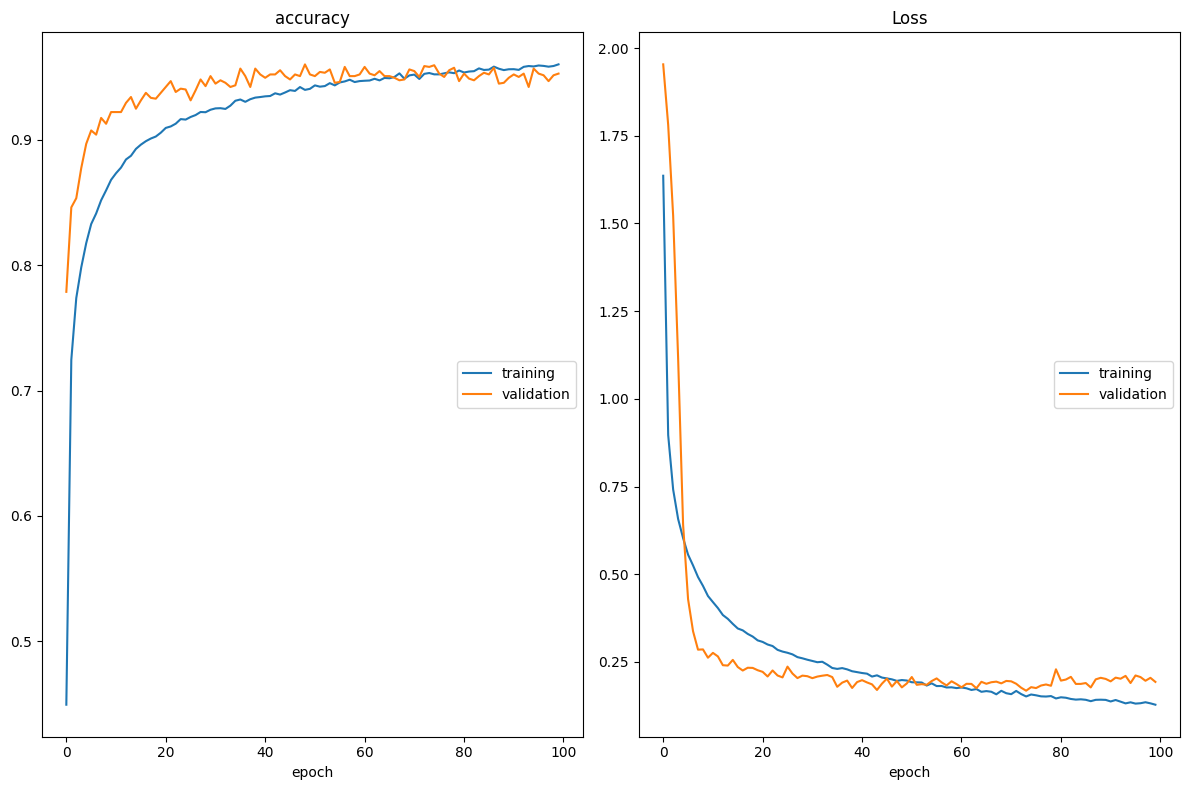

accuracy
	training         	 (min:    0.450, max:    0.960, cur:    0.960)
	validation       	 (min:    0.779, max:    0.960, cur:    0.953)
Loss
	training         	 (min:    0.128, max:    1.636, cur:    0.128)
	validation       	 (min:    0.168, max:    1.953, cur:    0.193)


In [14]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Шикарный вариант, эту аугментацию обязательно надо использовать, не переобучается за счёт affine и perspective и выдаёт отличные результаты из-за jitter

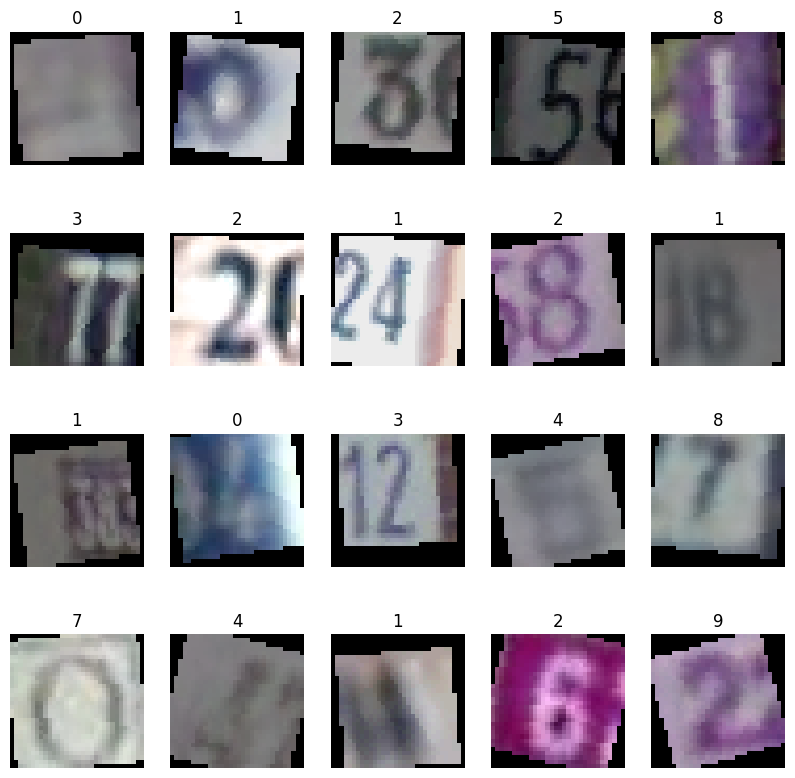

In [7]:
transformer5 = tv.transforms.Compose([
    posterizer,
    jitter,
    affine,
])
draw_aug_ds(transformer5)

In [16]:
train_ds.transform = transformer5
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

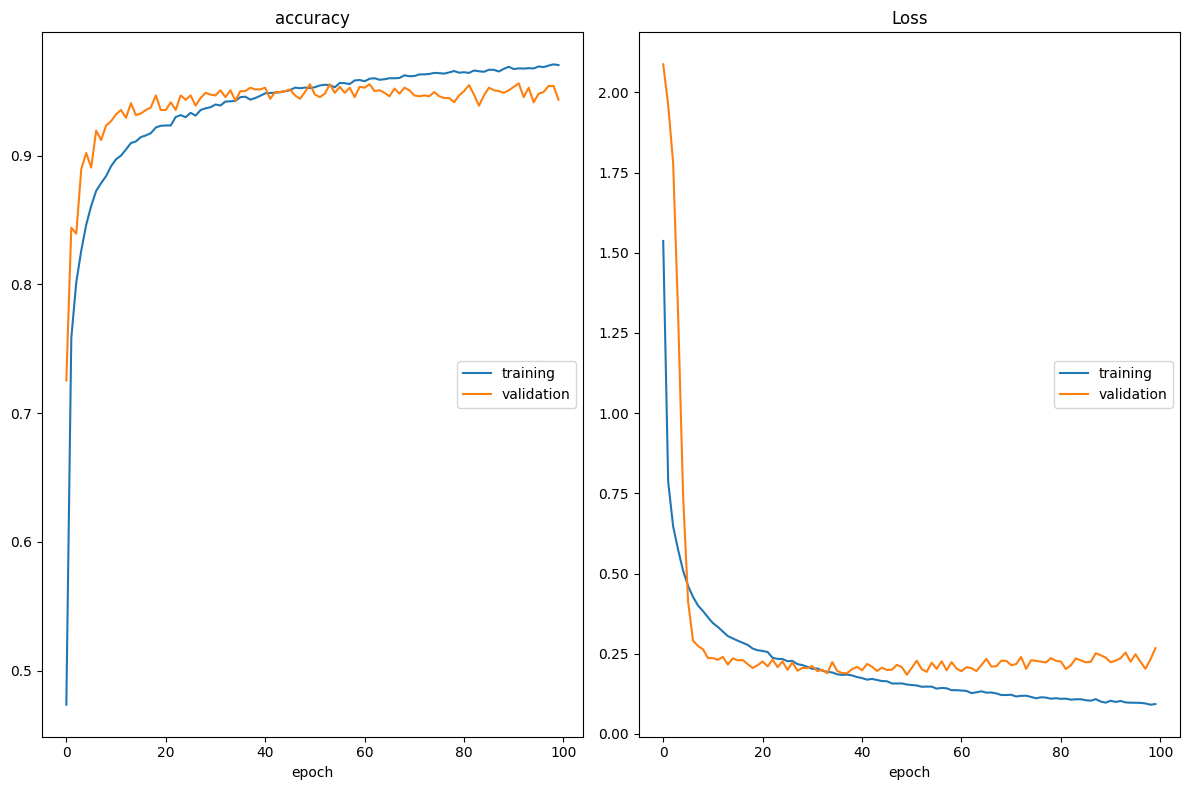

accuracy
	training         	 (min:    0.474, max:    0.971, cur:    0.970)
	validation       	 (min:    0.725, max:    0.956, cur:    0.943)
Loss
	training         	 (min:    0.091, max:    1.537, cur:    0.093)
	validation       	 (min:    0.184, max:    2.088, cur:    0.267)


In [17]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Модель показывает высокие результаты, стоит использовать

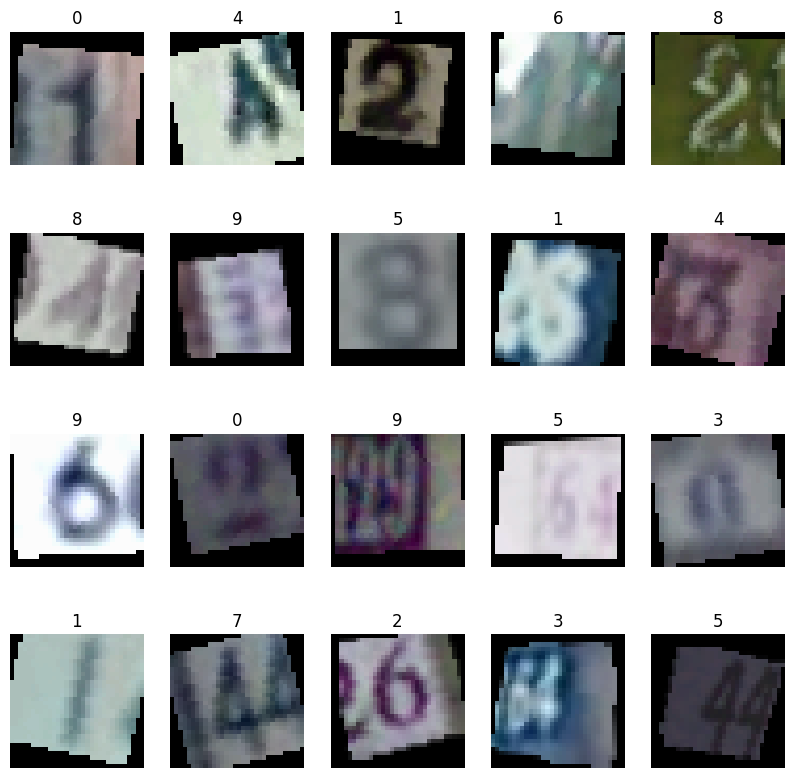

In [18]:
transformer6 = tv.transforms.Compose([
    posterizer,
    perspective
])
draw_aug_ds(transformer6)

In [19]:
train_ds.transform = transformer6
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

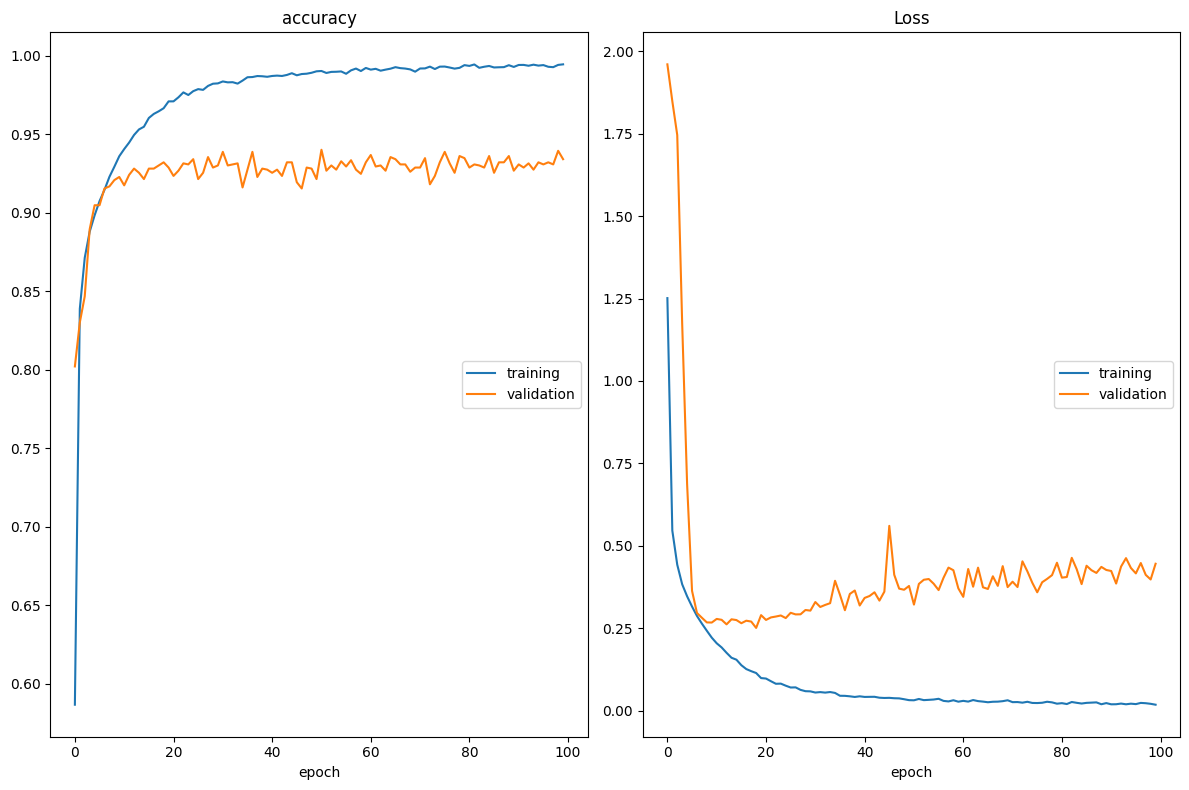

accuracy
	training         	 (min:    0.587, max:    0.994, cur:    0.994)
	validation       	 (min:    0.802, max:    0.940, cur:    0.934)
Loss
	training         	 (min:    0.018, max:    1.251, cur:    0.018)
	validation       	 (min:    0.251, max:    1.960, cur:    0.445)


In [20]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Модель не переобучается, но и не показывает очень хороших результатов

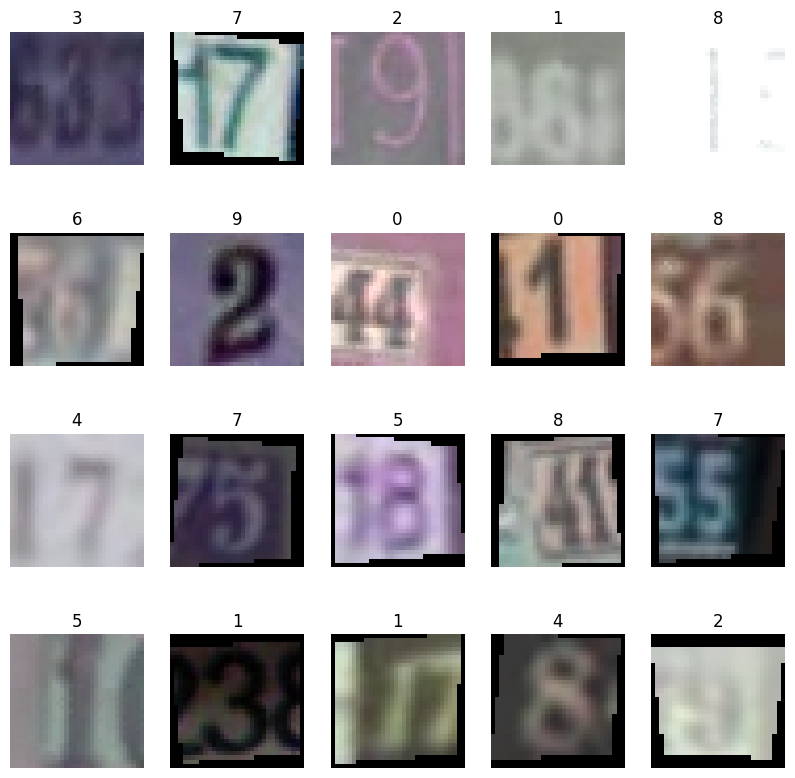

In [8]:
transformer7 = tv.transforms.Compose([
    jitter,
    inverter,
    perspective
])
draw_aug_ds(transformer7)

In [22]:
train_ds.transform = transformer7
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

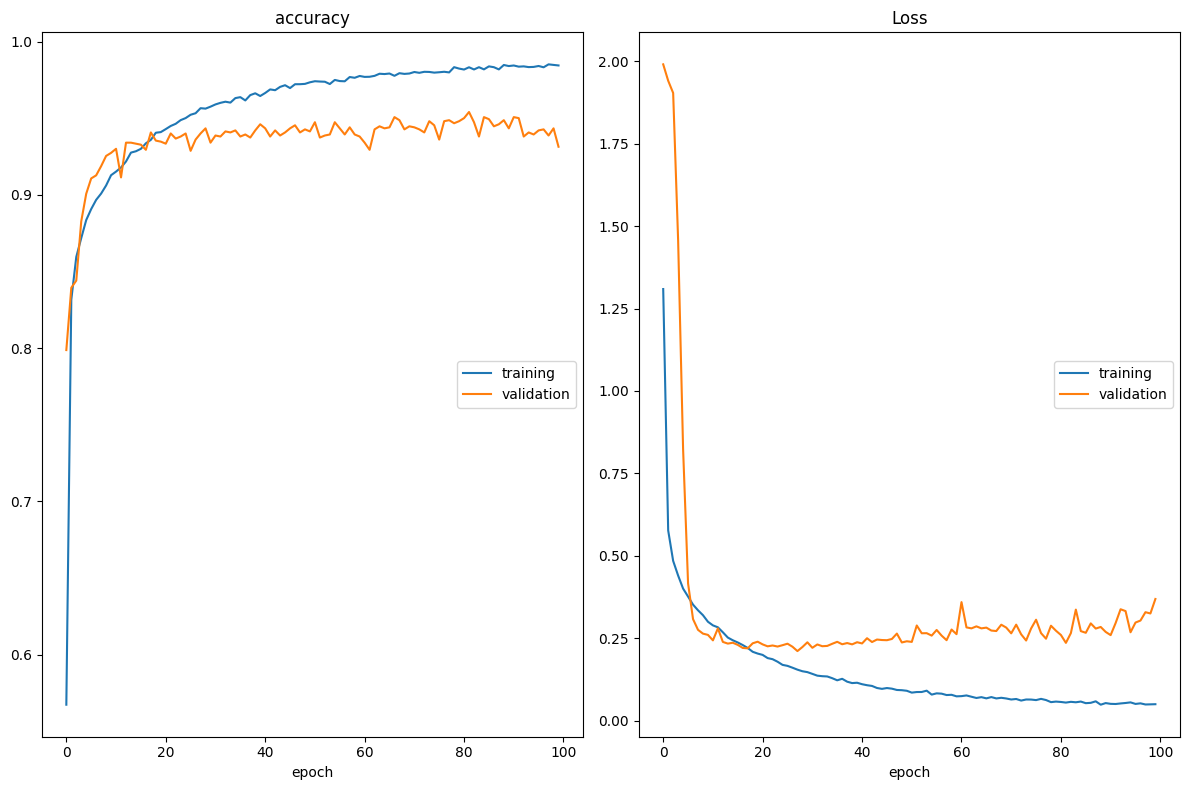

accuracy
	training         	 (min:    0.567, max:    0.985, cur:    0.984)
	validation       	 (min:    0.799, max:    0.954, cur:    0.931)
Loss
	training         	 (min:    0.048, max:    1.309, cur:    0.050)
	validation       	 (min:    0.211, max:    1.991, cur:    0.369)


In [23]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Результаты очень хорошие, стоит использовать

## Далее следуют модели с crop аугментацией, поэтому нам нужно изменить входной размер картинки

In [8]:
model_retrain_crop = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 22, 3), batch_size=512),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_retrain_crop.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (512, 26, 20, 32)         896       
                                                                 
 conv2d_1 (Conv2D)           (512, 24, 18, 64)         18496     
                                                                 
 batch_normalization (BatchN  (512, 24, 18, 64)        256       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (512, 12, 9, 64)         0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (512, 10, 7, 64)          36928     
                                                                 
 average_pooling2d_1 (Averag  (512, 5, 3, 64)          0

также поменяем датасеты, потому что валидационный остался без изменения размеров...

In [9]:
from sklearn.model_selection import train_test_split

data_all = open_f('repaired_data_train', back=0)

shuffle = np.random.permutation(data_all['images'].shape[0])
train_images_full = data_all['images'][shuffle]
train_labels_full = data_all['labels'][shuffle]

train_ds_x, val_ds_x, train_ds_y, val_ds_y = train_test_split(train_images_full, train_labels_full, test_size=0.07)

train_ds_crop = DataSequence(train_ds_x, train_ds_y, None, batch_size=512)
val_ds_crop = DataSequence(val_ds_x, val_ds_y, crop, batch_size=512)

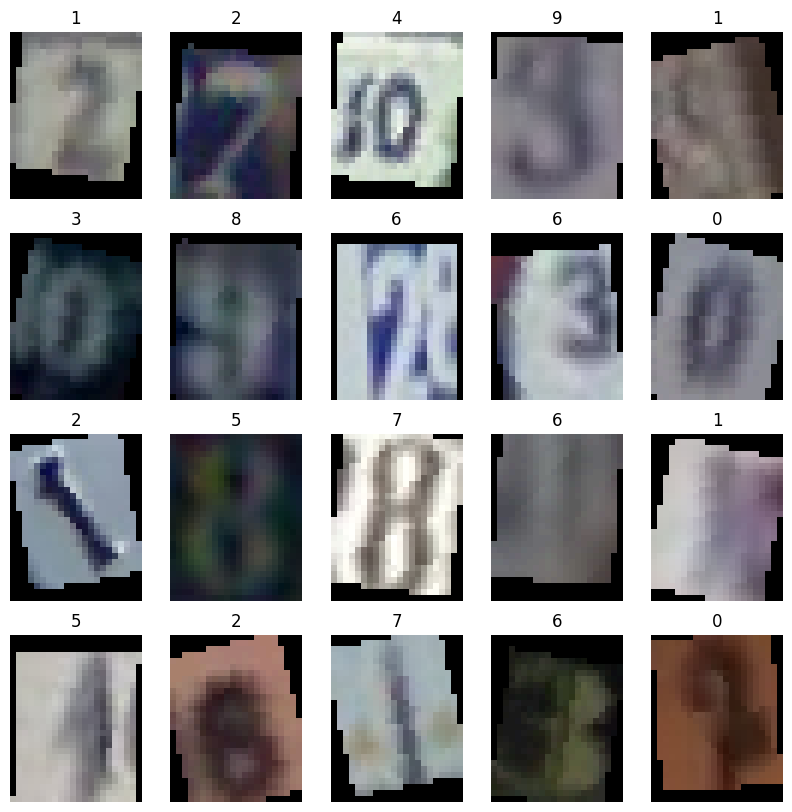

In [9]:
transformer8 = tv.transforms.Compose([
    crop,
    posterizer,
    affine
])
draw_aug_ds(transformer8)

In [13]:
train_ds_crop.transform = transformer8
model = tf.keras.models.clone_model(model_retrain_crop)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

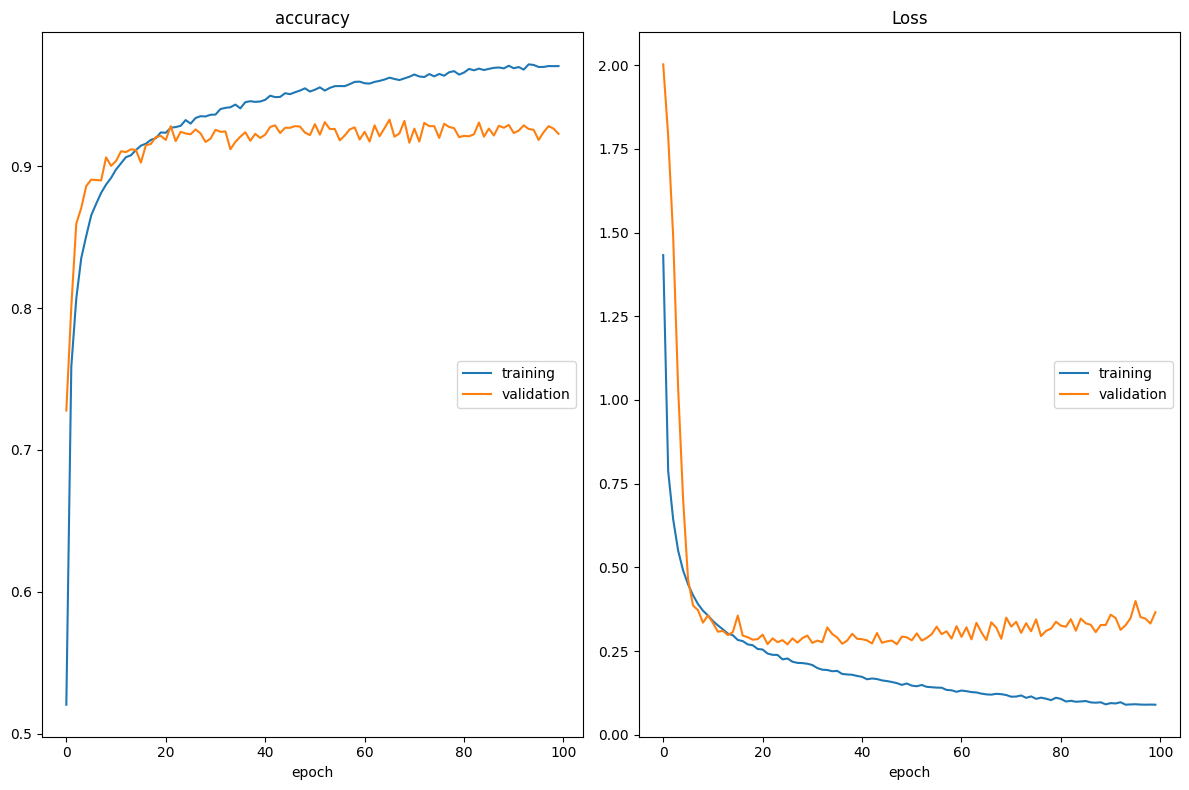

accuracy
	training         	 (min:    0.520, max:    0.972, cur:    0.971)
	validation       	 (min:    0.728, max:    0.933, cur:    0.923)
Loss
	training         	 (min:    0.090, max:    1.433, cur:    0.090)
	validation       	 (min:    0.270, max:    2.002, cur:    0.366)


In [14]:
model.fit(train_ds_crop, validation_data=val_ds_crop, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Модель не переобучается, но результаты не самые высокие

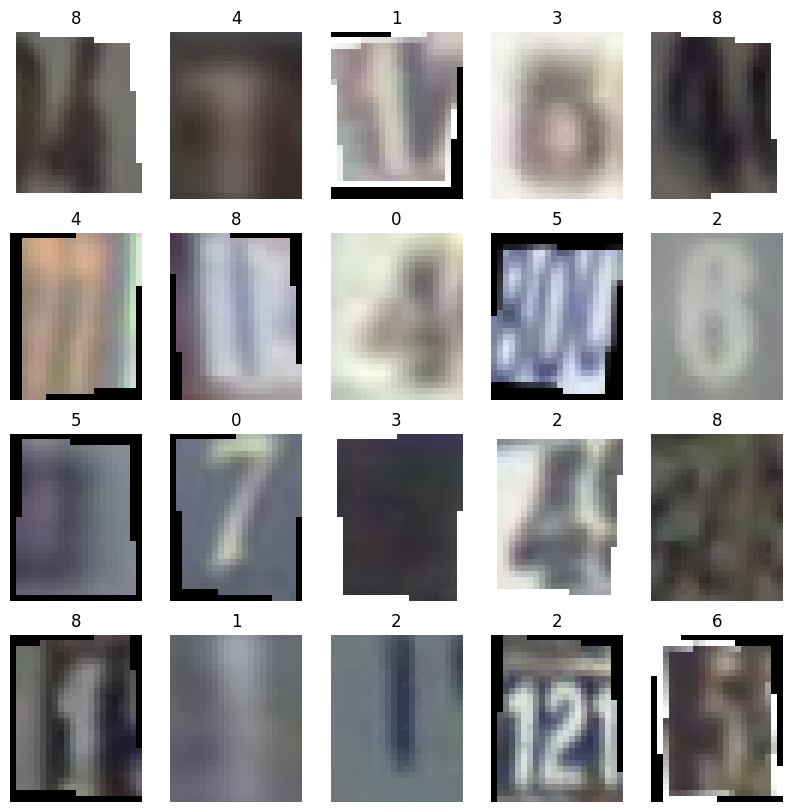

In [12]:
transformer9 = tv.transforms.Compose([
    crop,
    inverter,
    perspective,
])
draw_aug_ds(transformer9)

In [13]:
train_ds_crop.transform = transformer9
model = tf.keras.models.clone_model(model_retrain_crop)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

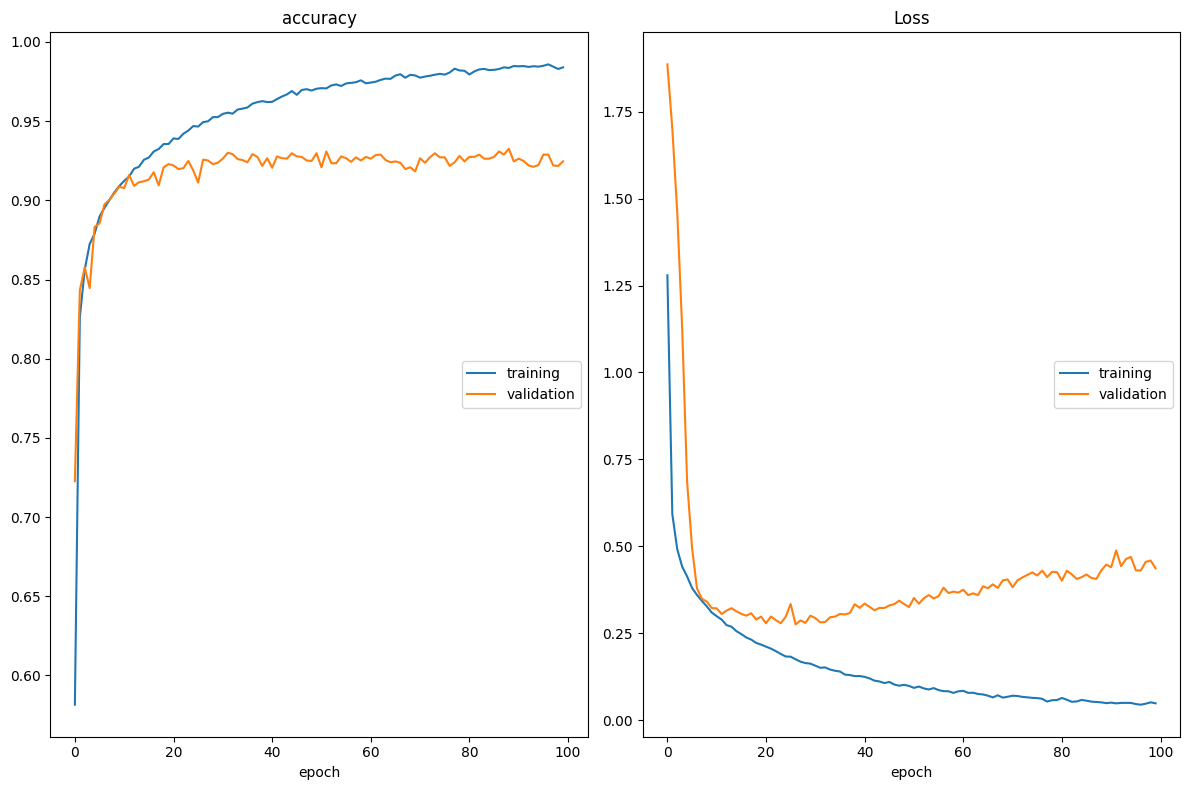

accuracy
	training         	 (min:    0.582, max:    0.986, cur:    0.984)
	validation       	 (min:    0.723, max:    0.933, cur:    0.925)
Loss
	training         	 (min:    0.044, max:    1.279, cur:    0.048)
	validation       	 (min:    0.275, max:    1.886, cur:    0.437)


In [14]:
model.fit(train_ds_crop, validation_data=val_ds_crop, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

Аналогично прошлой модели, результаты не самые лучшие

----
# Вывод:
### Лучшие виды аугментации:
```python
transformer4 = tv.transforms.Compose([
    jitter,
    affine,
    perspective
])
accuracy: 0.960
transformer5 = tv.transforms.Compose([
    posterizer,
    jitter,
    affine,
])
accuracy: 0.956
transformer7 = tv.transforms.Compose([
    jitter,
    inverter,
    perspective
])
accuracy: 0.954


Составим ещё 4 модели, комбинируя эти виды аугментации

In [9]:
train_ds.transform = [transformer4, transformer5, transformer7]
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

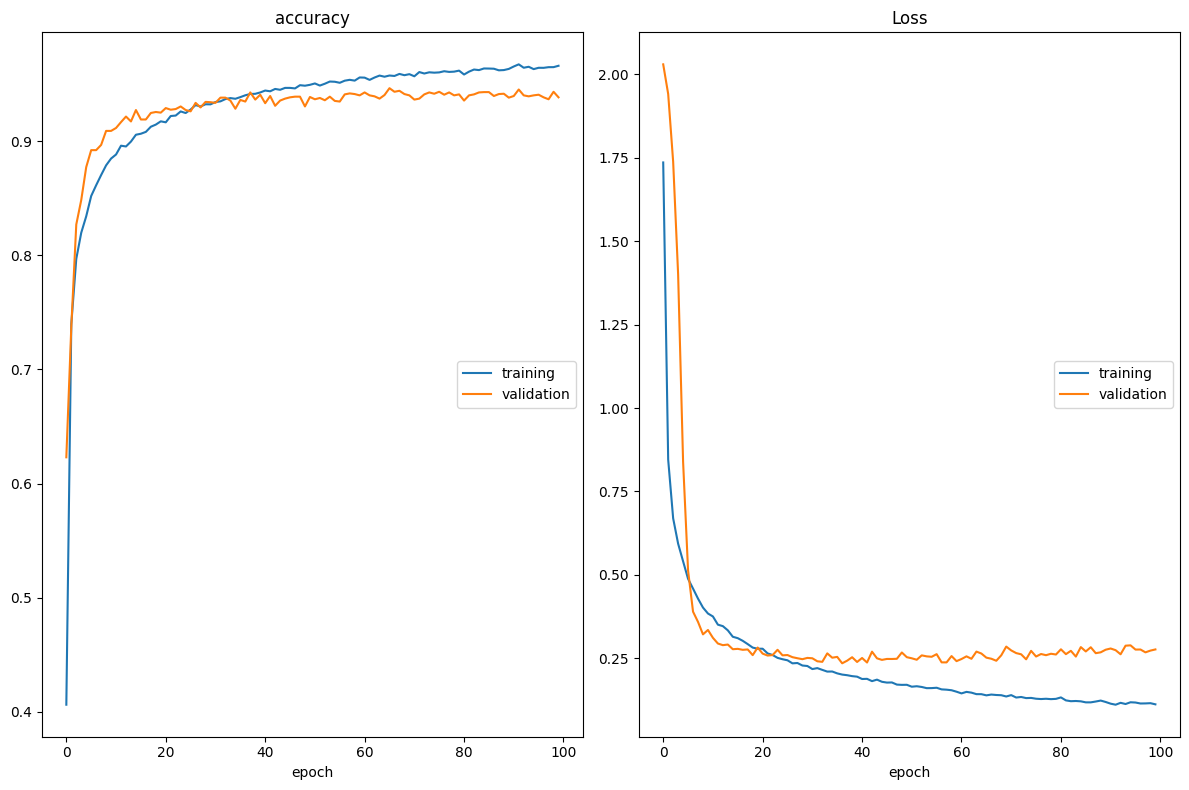

accuracy
	training         	 (min:    0.406, max:    0.967, cur:    0.966)
	validation       	 (min:    0.623, max:    0.946, cur:    0.938)
Loss
	training         	 (min:    0.111, max:    1.736, cur:    0.112)
	validation       	 (min:    0.235, max:    2.029, cur:    0.277)


In [10]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

вывод

In [11]:
train_ds.transform = [transformer4, transformer5]
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

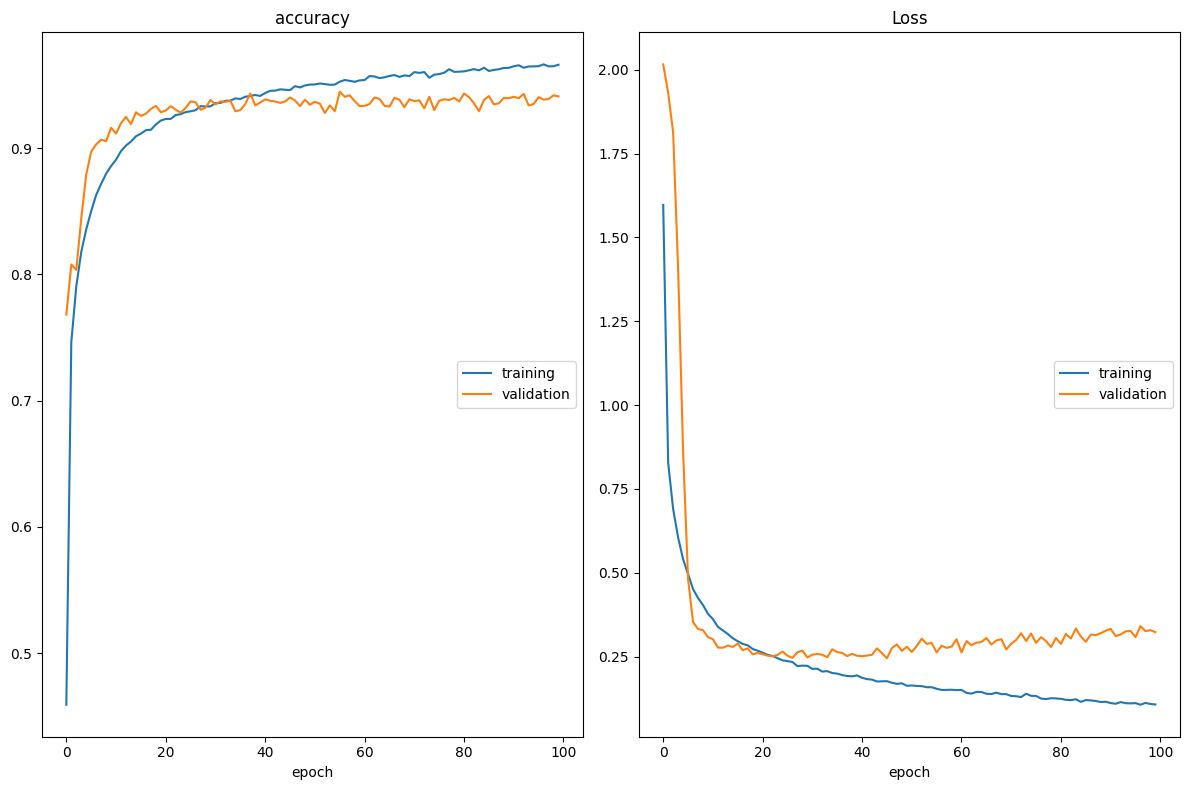

accuracy
	training         	 (min:    0.459, max:    0.966, cur:    0.966)
	validation       	 (min:    0.768, max:    0.945, cur:    0.941)
Loss
	training         	 (min:    0.107, max:    1.597, cur:    0.107)
	validation       	 (min:    0.245, max:    2.016, cur:    0.323)


In [12]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

вывод

In [13]:
train_ds.transform = [transformer4, transformer7]
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

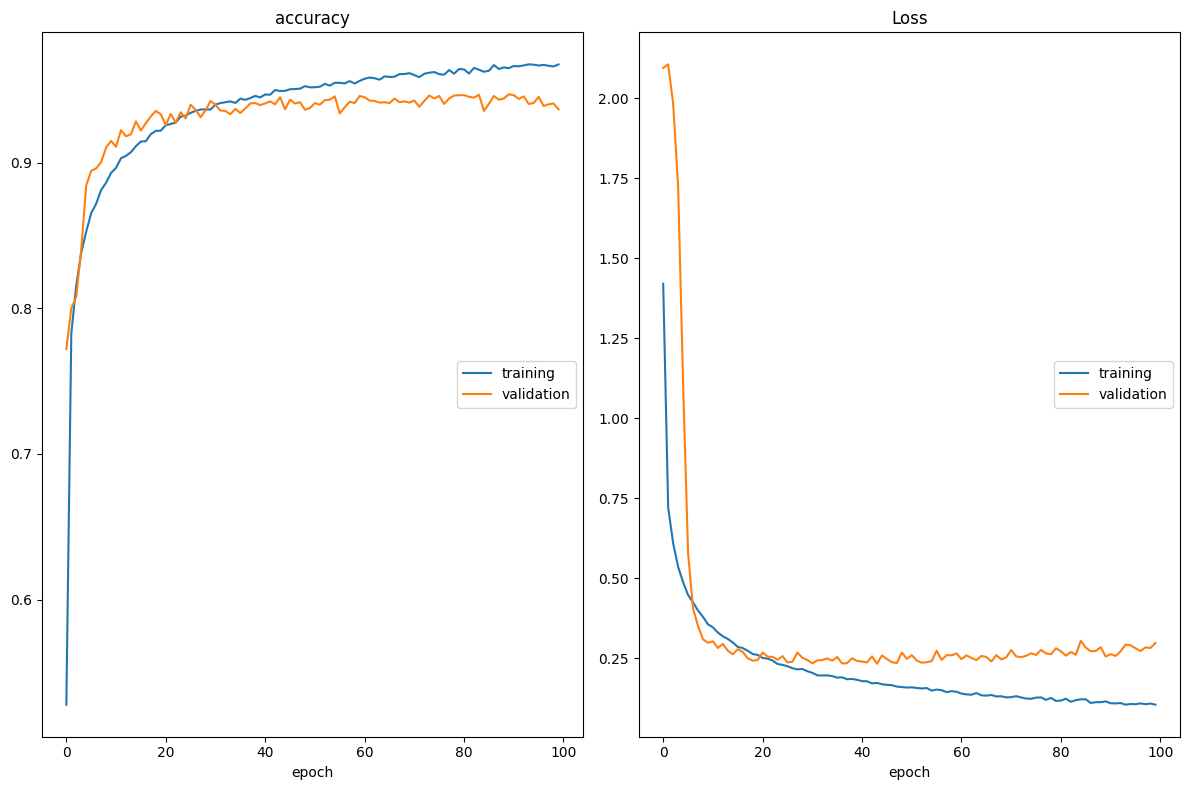

accuracy
	training         	 (min:    0.528, max:    0.967, cur:    0.967)
	validation       	 (min:    0.772, max:    0.947, cur:    0.937)
Loss
	training         	 (min:    0.105, max:    1.421, cur:    0.106)
	validation       	 (min:    0.233, max:    2.107, cur:    0.298)


In [14]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

вывод

In [15]:
train_ds.transform = [transformer5, transformer7]
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

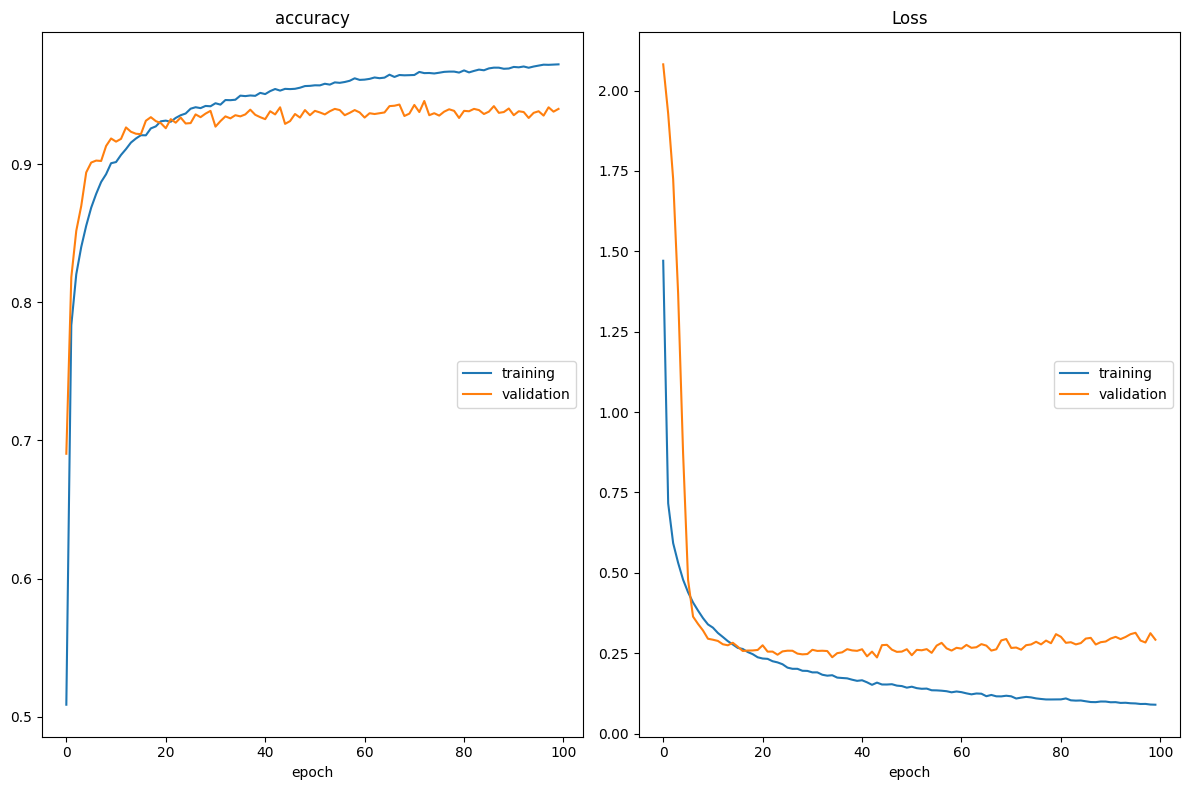

accuracy
	training         	 (min:    0.509, max:    0.972, cur:    0.972)
	validation       	 (min:    0.690, max:    0.946, cur:    0.940)
Loss
	training         	 (min:    0.090, max:    1.471, cur:    0.090)
	validation       	 (min:    0.237, max:    2.081, cur:    0.292)


In [16]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

вывод

----
# Вывод:

In [20]:
!git add .
!git commit -m "9th models"
!git push -f

On branch main
Your branch is up to date with 'origin/main'.

You have unmerged paths.
  (fix conflicts and run "git commit")
  (use "git merge --abort" to abort the merge)

Changes to be committed:
	new file:   notebooks/skewbek/SkipConnection/skip_conection.ipynb

Unmerged paths:
  (use "git add <file>..." to mark resolution)
	both modified:   notebooks/skewbek/Augmentation/aug_models.ipynb

